In [5]:
import pandas as pd
import csv
from datetime import datetime
import matplotlib.pyplot as plt
%matplotlib inline

![DKB Logo](https://upload.wikimedia.org/wikipedia/commons/d/d4/Deutsche_Kreditbank_AG_Logo_2016.svg)

## Please set these parameters

In [196]:
accountname = '2024_Umsatzliste' # set filename of the csv

# 0 or less means analyse all months
number_of_last_months_to_analyse = 10

### Read csv
Works for DKB csv as of 2022-12-31.

In [197]:
csv_file= accountname+".csv"
headerSize = 4
data = pd.read_csv(csv_file, index_col='Buchungsdatum',
# data = pd.read_csv(csv_file,
                   header=headerSize, sep=',', quoting=1, parse_dates=True, dayfirst=True)
print(data.head())

              Wertstellung   Status Zahlungspflichtige*r  \
Buchungsdatum                                              
2024-10-24        24.10.24  Gebucht     Paul Kohlschmidt   
2024-10-24        24.10.24  Gebucht               ISSUER   
2024-10-24        24.10.24  Gebucht               ISSUER   
2024-10-24        24.10.24  Gebucht               ISSUER   
2024-10-24        24.10.24  Gebucht               ISSUER   

                        Zahlungsempfänger*in        Verwendungszweck  \
Buchungsdatum                                                          
2024-10-24                Christoph Gerhardt               Sky, DAZN   
2024-10-24                   H.M.DE0673/BONN  VISA Debitkartenumsatz   
2024-10-24       RESTAURANT..THE.PROTEA/BONN  VISA Debitkartenumsatz   
2024-10-24                      TK.Maxx/Bonn  VISA Debitkartenumsatz   
2024-10-24     KAUFLAND.ILMENAU.4380/ILMENAU  VISA Debitkartenumsatz   

              Umsatztyp                    IBAN Betrag (€) Gläubiger-ID  \

In [198]:
# # Read metadata
with open(csv_file,"r") as f:
    reader = csv.reader(f)
    metadata = {}
    for i, row in enumerate(reader):
        if i<3:
            if "Kontostand" in row[0]:
                end_balance = float(row[1][:-2].replace(".","").replace(",","."))

end_date = datetime.strptime(data.iloc[0][0],"%d.%m.%y").date()
start_date = datetime.strptime(data.iloc[-1][0],"%d.%m.%y").date()

In [199]:
print("start:",start_date)
print("end:",end_date)
print("end balance:",end_balance)

start: 2024-01-02
end: 2024-10-24
end balance: 3440.13


## Named Columns

In [200]:
party = "Zahlungsempfänger*in"
category = "Kategorie"
amount = "Betrag (€)"
cause = "Verwendungszweck"
posting_text = "Kundenreferenz"
balance = "Kontostand (EUR)"

### Cleanup

In [201]:
# Fix US / EU decimal-point/comma
print(data[amount])
data[amount] = data[amount].str.replace('.','')
data[amount] = data[amount].str.replace(',','.')
data[amount] = data[amount].astype('float')

# avoid nan being interpreted as float in specific columns
data[party] = data[party].astype(str)
data[cause] = data[cause].astype(str)
data[posting_text] = data[posting_text].astype(str)

Buchungsdatum
2024-10-24         31
2024-10-24     -29,98
2024-10-24        -25
2024-10-24     -15,98
2024-10-24    -219,52
               ...   
2024-01-02      57,96
2024-01-02     -14,91
2024-01-02      -6,99
2024-01-02       -334
2024-01-02       -350
Name: Betrag (€), Length: 1041, dtype: object


/tmp/ipykernel_2055817/188290710.py:3: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  data[amount] = data[amount].str.replace('.','')


In [202]:
data.head()

,Wertstellung,Status,Zahlungspflichtige*r,Zahlungsempfänger*in,Verwendungszweck,Umsatztyp,IBAN,Betrag (€),Gläubiger-ID,Mandatsreferenz,Kundenreferenz
Buchungsdatum,,,,,,,,,,,
2024-10-24,24.10.24,Gebucht,Paul Kohlschmidt,Christoph Gerhardt,"Sky, DAZN",Eingang,DE43500105175424577951,31.00,NaN,NaN,nan
2024-10-24,24.10.24,Gebucht,ISSUER,H.M.DE0673/BONN,VISA Debitkartenumsatz,Ausgang,DE96120300009005290904,-29.98,NaN,NaN,484297621132040
2024-10-24,24.10.24,Gebucht,ISSUER,RESTAURANT..THE.PROTEA/BONN,VISA Debitkartenumsatz,Ausgang,DE96120300009005290904,-25.00,NaN,NaN,484297730797840
2024-10-24,24.10.24,Gebucht,ISSUER,TK.Maxx/Bonn,VISA Debitkartenumsatz,Ausgang,DE96120300009005290904,-15.98,NaN,NaN,484297637675324
2024-10-24,24.10.24,Gebucht,ISSUER,KAUFLAND.ILMENAU.4380/ILMENAU,VISA Debitkartenumsatz,Ausgang,DE96120300009005290904,-219.52,NaN,NaN,484296267243867


### Remove small transactions to avoid noise

In [203]:
data = data[abs(data[amount]) > 0.01]

### Inverse Dataframe to have first day first and filter by time-range

In [204]:
from dateutil.relativedelta import relativedelta
if number_of_last_months_to_analyse > 0:
    start_date = end_date - relativedelta(months=number_of_last_months_to_analyse)
    
print(f"Analysing time range: {start_date} -> {end_date}")
data = data.loc[str(start_date):str(end_date)]
data = data.iloc[::-1]

Analysing time range: 2023-12-24 -> 2024-10-24


/tmp/ipykernel_2055817/3910136542.py:6: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  data = data.loc[str(start_date):str(end_date)]


In [205]:
fr = data.index[0]
to = data.index[-1]
print(fr,"->",to)

2024-01-02 00:00:00 -> 2024-10-24 00:00:00


### Compute balance at each transaction

In [206]:
data_balance = data[amount].sum().round(2)
start_balance = end_balance - data_balance
data[balance] = data[amount].cumsum()+start_balance

In [207]:
print("start",start_balance)
print("end",end_balance)
print("balance during csv timespan",data_balance)

start 4468.63
end 3440.13
balance during csv timespan -1028.5


## Balance over time

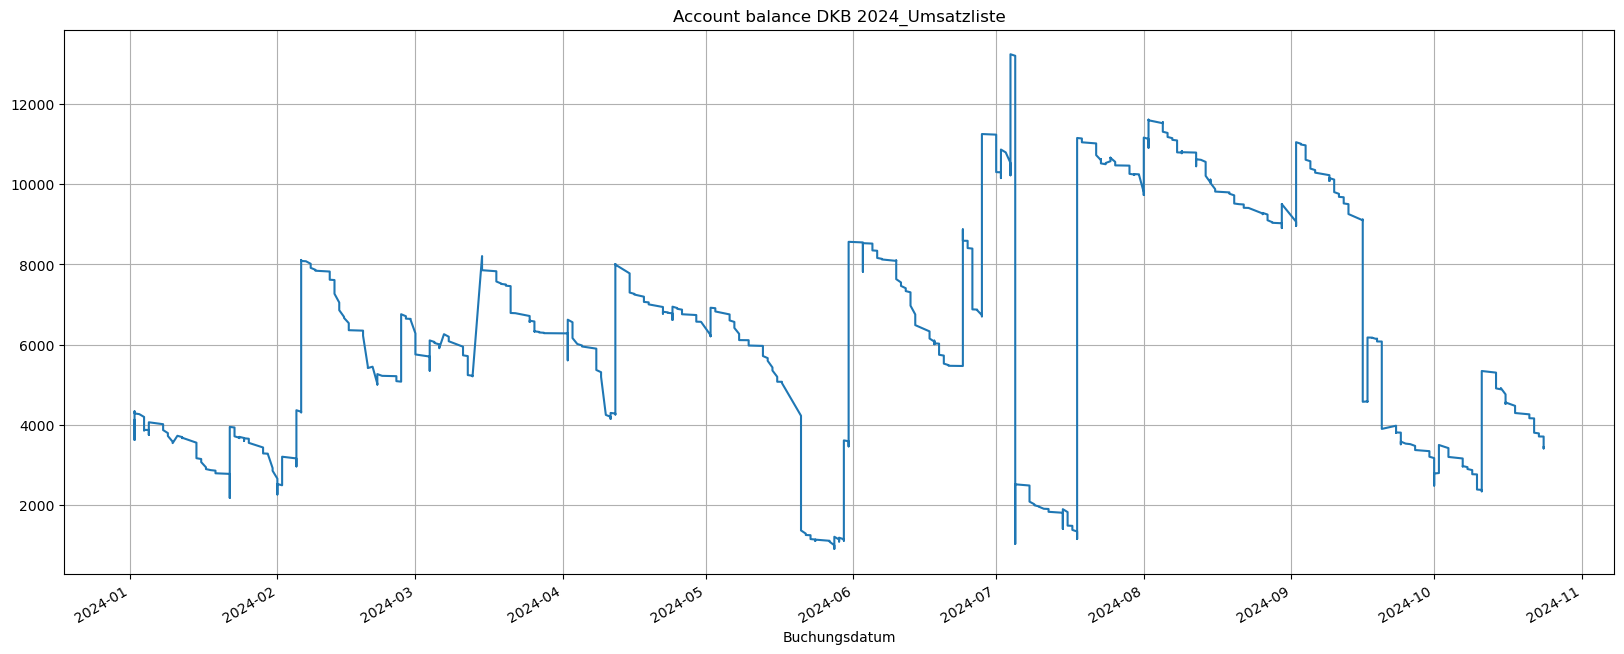

In [208]:
data[balance].plot(
    title='Account balance DKB %s' % accountname,
    grid=True,
    figsize=(20,8)
);

## Breakdown by transaction party

In [209]:
print(data.groupby(party).agg({amount:"sum"}))
print(data)
empfgroup = data.groupby(party).agg({amount:"sum"})

                                                    Betrag (€)
Zahlungsempfänger*in                                          
213 - MAXI 470                                          -17.12
213...MAXI.470/CACAK                                    -16.49
214...TEMPO.005/CACAK                                   -32.07
305.HARRRISON.ST.SP/Seattle                             -76.88
7-Eleven                                                 -2.58
...                                                        ...
backWerk                                                 -1.60
dm-drogerie                                            -558.87
eprimo GmbH                                    ...     -129.00
tegut                                                   -27.80
vtours GmbH                                             -68.00

[267 rows x 1 columns]
              Wertstellung   Status  \
Buchungsdatum                         
2024-01-02        02.01.24  Gebucht   
2024-01-02        02.01.24  Gebucht   
2

In [210]:
# Short the names
empfgroup.index = [str(i)[:30] for i in empfgroup.index]

In [211]:
empfgroup[amount].head()


213 - MAXI 470                -17.12
213...MAXI.470/CACAK          -16.49
214...TEMPO.005/CACAK         -32.07
305.HARRRISON.ST.SP/Seattle   -76.88
7-Eleven                       -2.58
Name: Betrag (€), dtype: float64

In [212]:
empfgroup = empfgroup.sort_values(amount,ascending=False)
gutschrift = empfgroup[amount] > 0
colors = list( map(lambda x: "g" if x else "r" , gutschrift) )

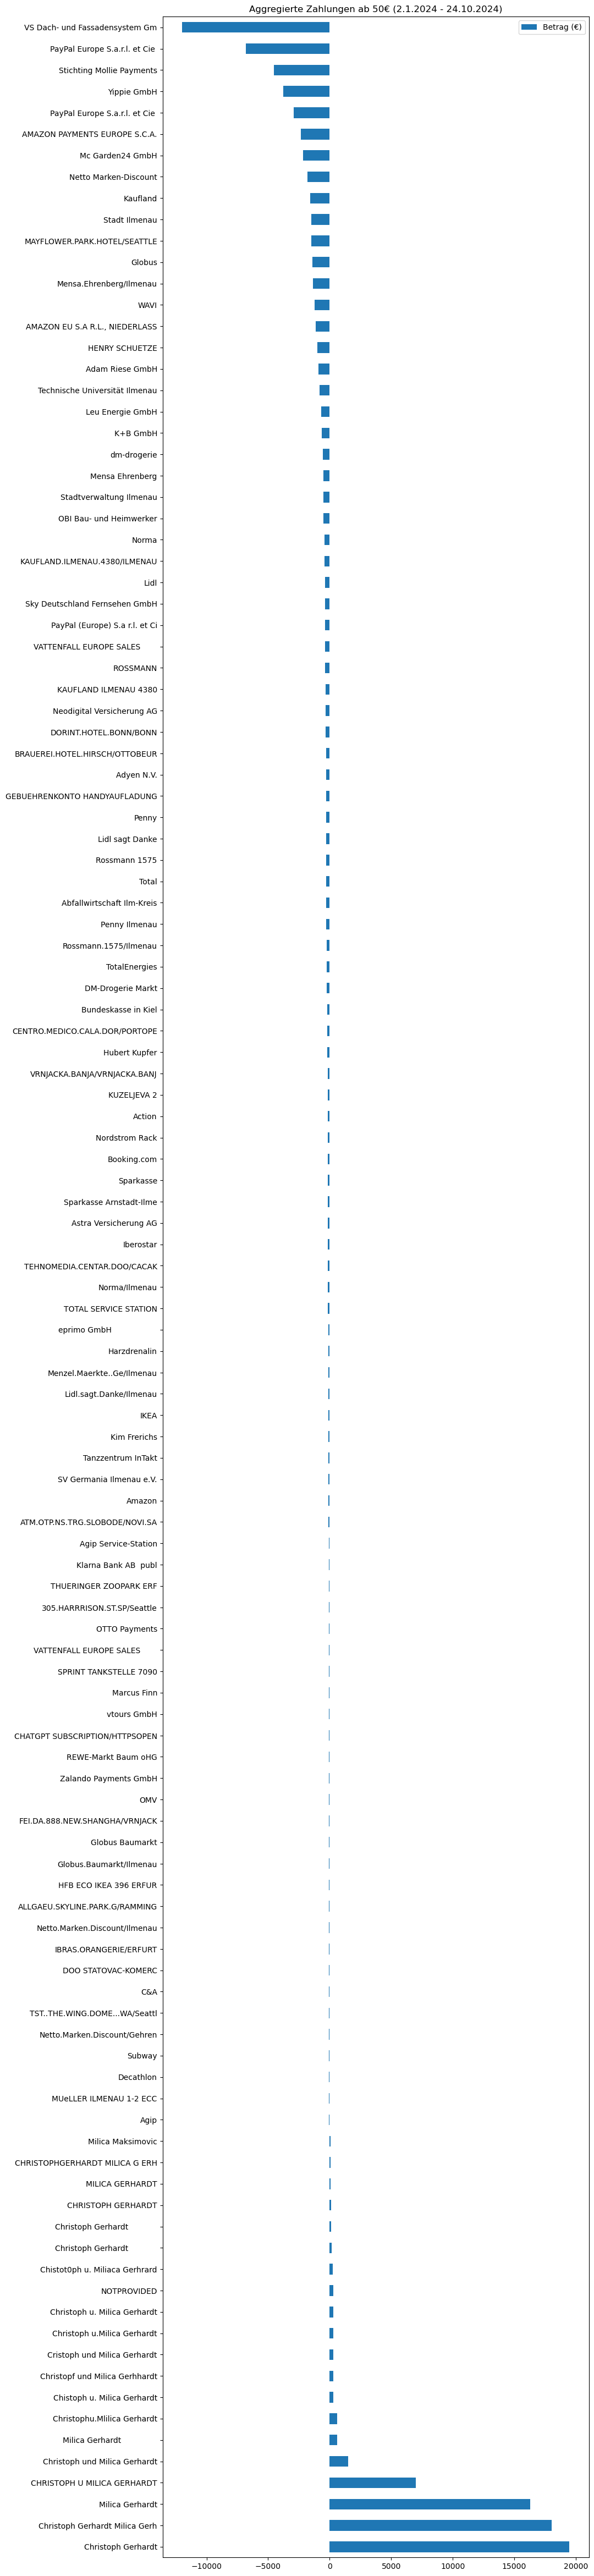

In [213]:
empfgroup[empfgroup[amount].abs() > 50].plot.barh(
    figsize=(10,60),
    title=u'Aggregierte Zahlungen ab 50€ (%i.%i.%i - %i.%i.%i)' % (fr.day, fr.month, fr.year, to.day, to.month, to.year)
  );

In [214]:
data.head()

,Wertstellung,Status,Zahlungspflichtige*r,Zahlungsempfänger*in,Verwendungszweck,Umsatztyp,IBAN,Betrag (€),Gläubiger-ID,Mandatsreferenz,Kundenreferenz,Kontostand (EUR)
Buchungsdatum,,,,,,,,,,,,
2024-01-02,02.01.24,Gebucht,Christoph Gerhardt Milica Gerhardt,Leu Energie GmbH,138018791,Ausgang,DE73780608960102510510,-350.00,NaN,NaN,938026113,4118.63
2024-01-02,02.01.24,Gebucht,Christoph Gerhardt,Yippie GmbH,Abschlag (Gas) Dezember / 2023 Kunden-Nr. 6000...,Ausgang,DE52506521240026142141,-334.00,DE73ZZZ00002384370,-600075380-900081364-1,A1.600075380.900081364.32441844,3784.63
2024-01-02,02.01.24,Gebucht,ISSUER,C.A Haus 0547,VISA Debitkartenumsatz,Ausgang,DE96120300009005290904,-6.99,NaN,NaN,483363645144136,3777.64
2024-01-02,02.01.24,Gebucht,Milica Gerhardt,Astra Versicherung AG,"Kundennr: 27552, Rechnungsnr: 954351, Zahnzusa...",Ausgang,DE67545500100193238029,-14.91,DE45ZZZ00001921408,27552,ADVTXN969130,3762.73
2024-01-02,02.01.24,Gebucht,AMAZON PAYMENTS EUROPE S.C.A. ...,Milica Gerhardt ...,303-8174271-4781949 AMZN Mktp DE 1D8LD4ROIPH6SCC0,Eingang,DE87300308801908262006,57.96,NaN,NaN,1D8LD4ROIPH6SCC0,3820.69


## Breakdown by Category
We use some heuristics on the tranasaction details to put them into different categories.
All transactions within a category will be aggregated for a better overall analysis.
You may need to check the print output of the next cell and possibly adapt the mapping function for a better categorisation.

**the text will be lower cased before categorisation**

**Feel free to change these heuristic mappings - or adapt the code to map according to specififc transaction details.**

In [229]:
categories = {
    "Gastronomie": [
        "restaurant",
        "gastro",
        "dean david",
        "cafe",
        "baeckerei",
        "coffee fellows",
        "jim block",
        "don qui",
        "Osteria",
        "subway",
        "backhaus",
        "burger king",
        "campus suite",
        "juice.more",
        "Back",
        "Avni Terhani",
        "vegan",
        "thai",
        "indisch",
    ],
    "Supermarkt": [
        "lidl",
        "aldi",
        "edeka",
        "alnatura",
        "rewe",
        "norma",
        "netto",
        "kaufland",
        "penny",
        "tegut",
    ],
    "Drogerie": [
        "mueller",
        "rossmann",
        "dm",
    ],
    "Online Shopping":[
        "otto",
        "conrad elec",
        "amzn mktp",
        "amazon",
        "paypal",
    ],
    "Transport": [
        "FERNVERKEHR",
        "flixbus",
        "bahn",
        "PAYPAL .DBVERTR",
    ],
    "Reise": [
        "booking",
        "hotel",
        "airbnb",
        "mallorca",
        "iberostar",
        "ryanair",
        "airport",
        "flughafen"
    ],
    "Ausflug":[
        "zoo",
        "tierpark",
        "schwimmbad",
        "therme"
        "ega"],
    "project": [
        "openai",
        "google.cloud",
        "github",
    ],
    "Hobby": [
        "germania",
        "tanz",
    ],
    "Unterhaltung": [
        "magellan",
        "Amazon Prime",
        "paypal .steam",
        "netflix",
        "spotify"
    ],
    "Gesundheit": [
        "apotheke",
        "krankenversicherung",
        "krank",
        "arzt",
    ],
    "Bargeld": [
        "bargeld",
        "automat",
        "cash"
    ],
    "DKB": [
        "DKB",
        "KREDITBANK",
    ],
    "Kleidung":[
        "tk maxx",
        "deichmann",
        "primark",
        "h.m",
        "h.amp.m",        
        "c.a"
    ],
    "Haus": [
        "Kredit", 
        "Gebäude",
        "Abfall",
        ],
    "Energie":[
        "leu", 
        "eprimo",
        "yippie",
    ],
    "Versicherung":[
        "astra",
        "adam riese",
        "neodigital"
    ],
    "Tanken":[
        "aral",
        "total",
        "agip",
        "tank"
    ],
    "Mobilfunk":["handyaudladung"
    ]
    "Mittagessen": ["mensa", "henry schuetze"], 
    "investment": [],
    "emergency_fund":[],
    "uncategorized": [
        "PayPal (Europe)",
    ],
    "card_payment": [],
    "minor": [ # populated automatically
    ]
}

def mapToCategory(x):
    # use these transaction details to map to a category
    p = x[party].lower()
    pt = x[posting_text].lower()
    c = x[cause].lower()
    
    # manual mappings
    if "WERTP. ABRECHN".lower() in c or "Depot ".lower() in c or "WERTPAPIER".lower() in c:
        return "investment"
    
    if "miete ".lower() in c:
        return "miete"
    
    if "KREDITKARTENABRECHNUNG".lower() in c:
        return "card_payment"
    
    # mappings by category
    for cat, cat_words in categories.items():
        if any(map(lambda r: r.lower() in p, cat_words)) or any(map(lambda r: r.lower() in pt, cat_words)):
            return cat
    
    # debitcard. may need adaptation
    if "Debitk.20 VISA Debit".lower() in c:
        return "card_payment"
    
    return p

data[category] = data.apply(lambda x: mapToCategory(x), axis=1)

print(len(data[category].unique()),"categories")

print("============ uncategorized =================")
s = 0
for x in data[category].unique():
    ok = False
    
    for cat in categories.keys():
        if x == cat:
            ok = True

    if not ok:
        print(x)
        idx = data[category] == x
        s = s + abs(data[idx][amount].sum())
        
print("================================ sum of uncategorized: ",s) # todo. this doesn't seem to make sense ... 🤔

189 categories
============ uncategorized =================
milica gerhardt                                                       de
nya.kiddie spieler
christoph gerhardt
christoph u milica gerhardt
sky deutschland fernsehen gmbh co. kg
zur schortemuehle
stadt ilmenau
action 3597
gebuehrenkonto handyaufladung
zalando payments gmbh
technische universität ilmenau
milica gerhardt
bundeskasse in kiel
christophgerhardt milica g erhardt
wavi
schwimmhalle.eishalle i
menzel maerkte, ge
maec geiz handelsges. m
chistot0ph u. miliaca gerhrardt
hfb eco ikea 396 erfur
christoph gerhardt milica gerhardt
klarna
globus baumarkt
ditsch erfurt hauptbah
gate retail wizz eur
213 - maxi 470
doo statovac-komerc
kuzeljeva 2
stadtverwaltung ilmenau
gornji milanovac 1
sinsay gornji milanovac
kfc 389
christoph und milica gerhardt
mc pfennig ilmenau
vb thueringen mitte
obi bau- und heimwerker
eishalle.schwimmhalle
sparkasse mittelthuerin
sumup .trobnitzer getr
sparkasse arnstadt-ilme
k+b gmbh
globus.baumarkt/ilm

Breakdown by category. (Ignored transactions below 10€).

/tmp/ipykernel_2055817/1196912981.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  costs.loc[:,amount] = -costs[amount]


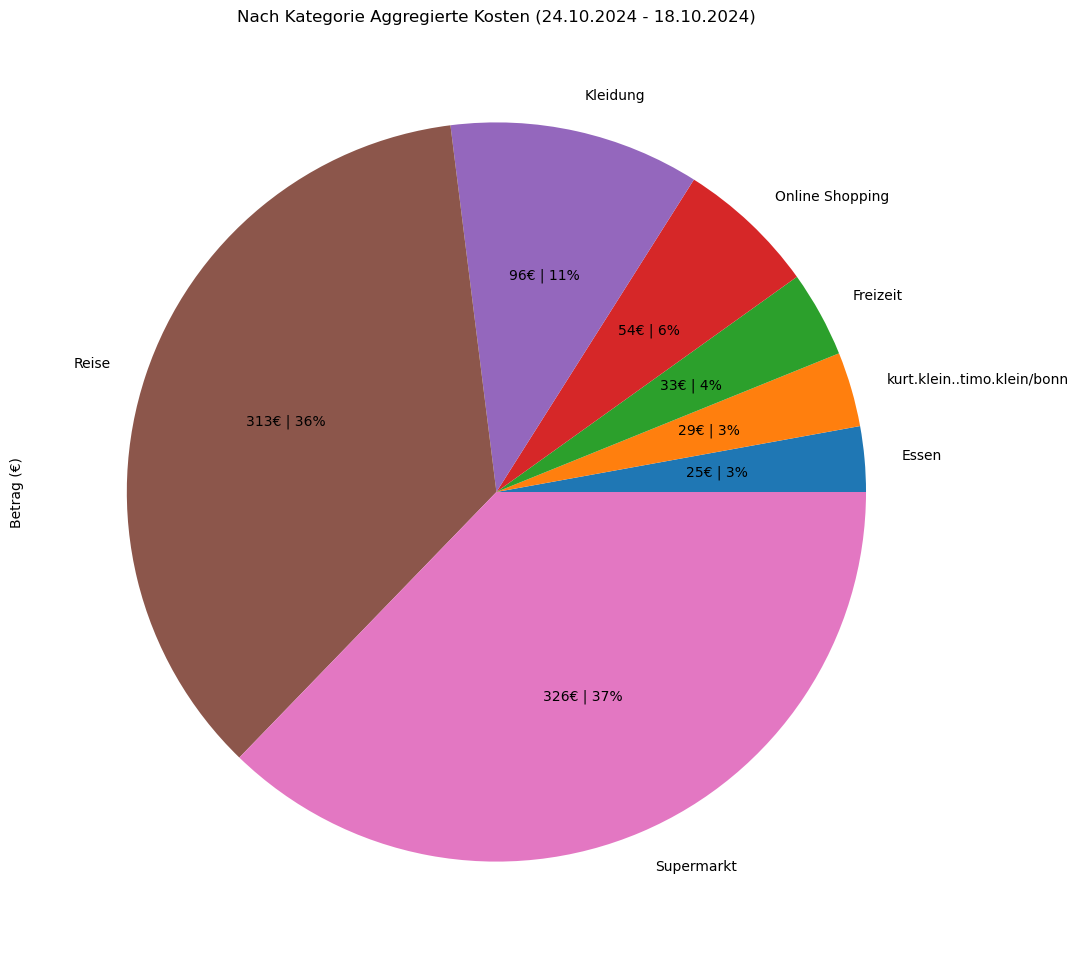

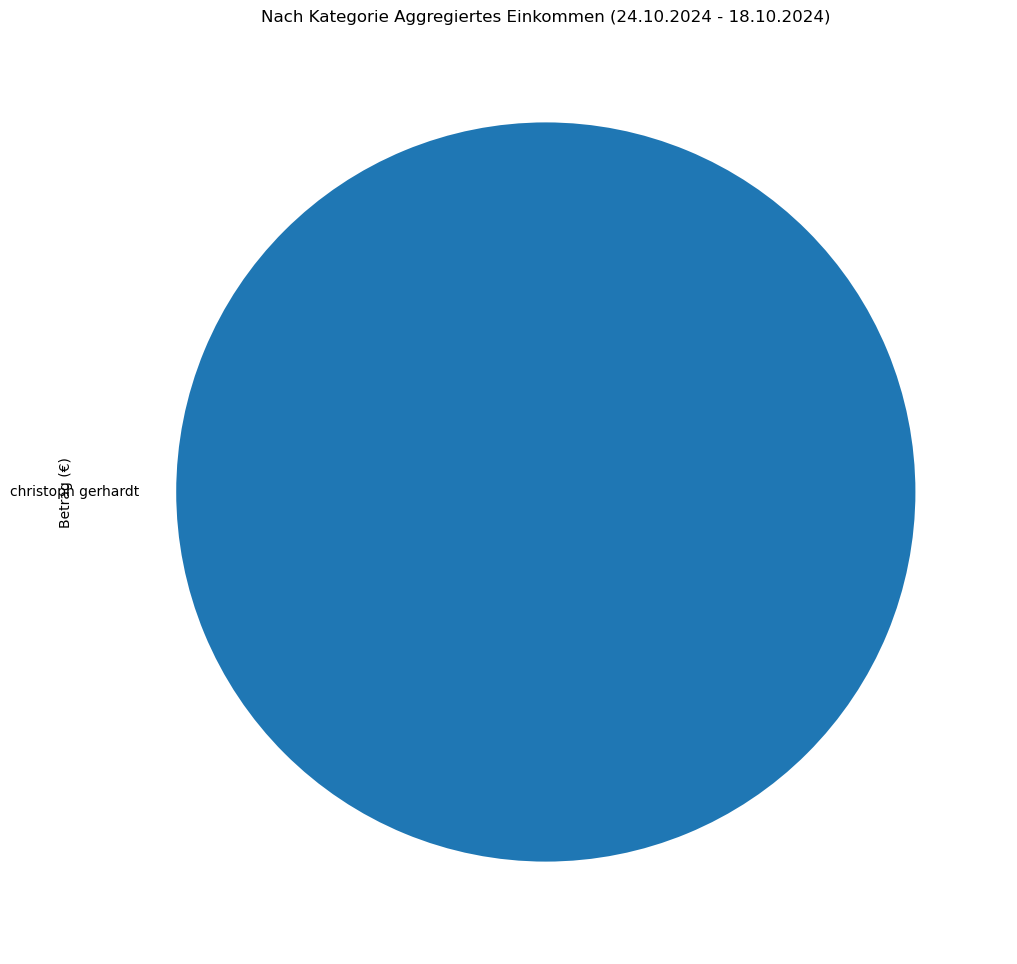

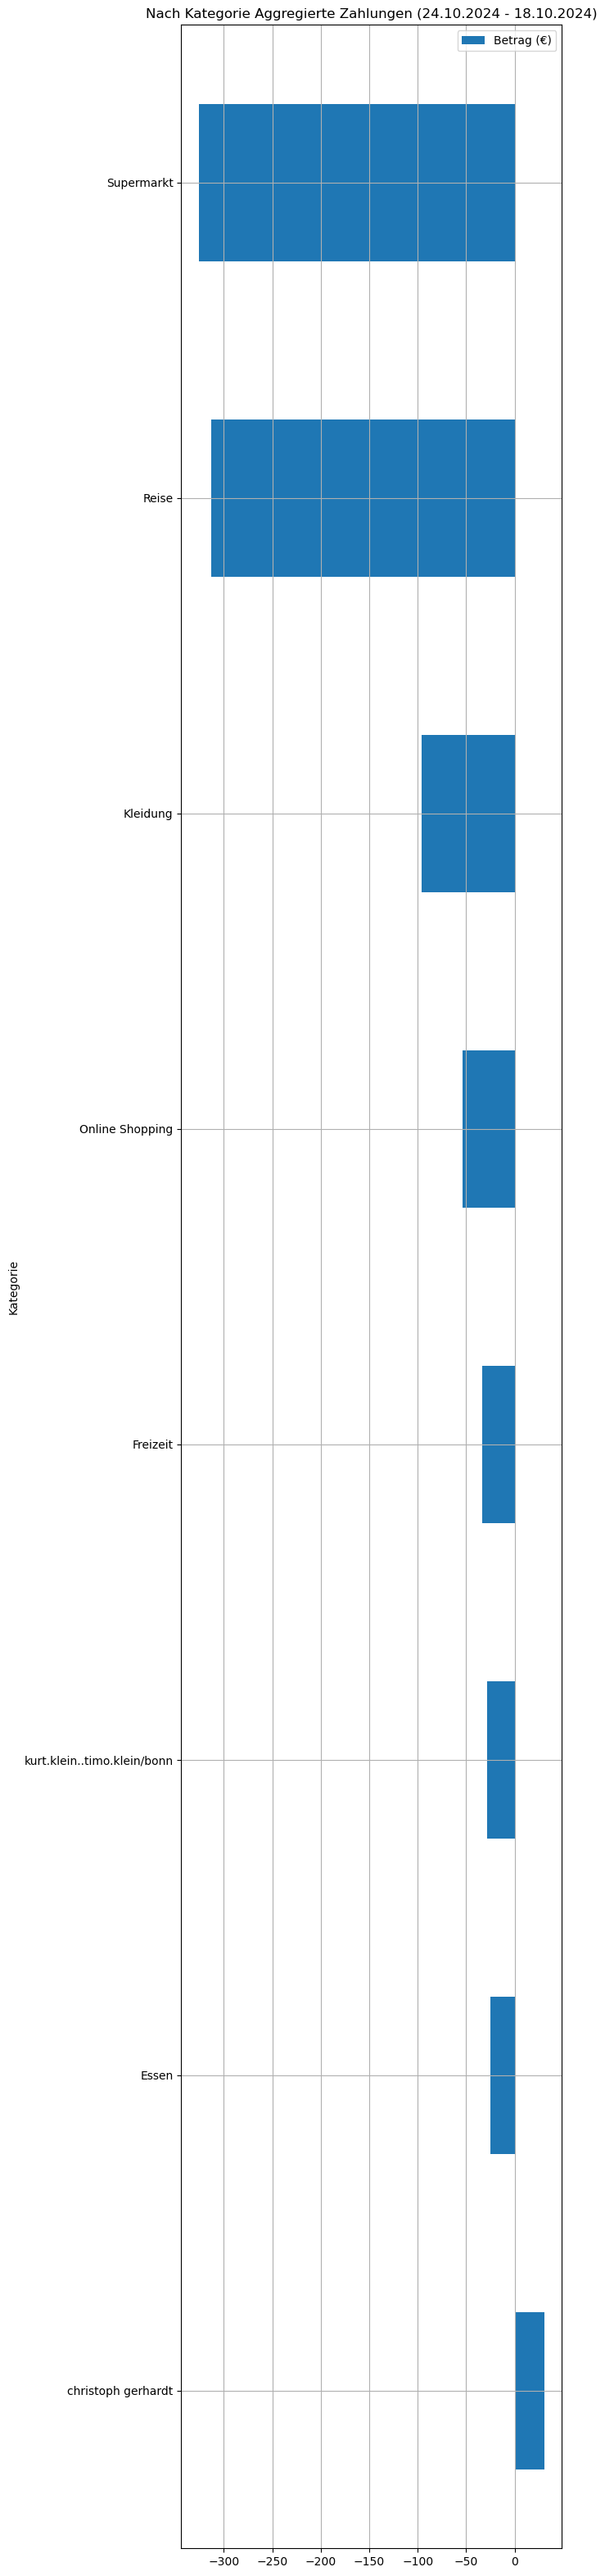

In [195]:
byCategory = data.groupby(category).agg({amount:"sum"}).sort_values(amount,ascending=False)
byCategory = byCategory[abs(byCategory[amount]) > 10]
    

costs = byCategory[byCategory[amount] < 0]
costs.loc[:,amount] = -costs[amount]

total_costs = costs[amount].sum()
costs.plot.pie(
    figsize=(12,12),
    y=amount,
    legend=None,
    autopct=lambda x: str(round(x/100*total_costs)) + "€ | " + str(round(x)) + "%",
    title=u'Nach Kategorie Aggregierte Kosten (%i.%i.%i - %i.%i.%i)' % (fr.day, fr.month, fr.year, to.day, to.month, to.year)
)
plt.show()

byCategory[byCategory[amount] > 0].plot.pie(
    figsize=(12,12),
    y=amount,
    legend=None,
    title=u'Nach Kategorie Aggregiertes Einkommen (%i.%i.%i - %i.%i.%i)' % (fr.day, fr.month, fr.year, to.day, to.month, to.year)
)
plt.show()


byCategory.plot.barh(
    figsize=(6,40),
    grid=True,
    title=u'Nach Kategorie Aggregierte Zahlungen (%i.%i.%i - %i.%i.%i)' % (fr.day, fr.month, fr.year, to.day, to.month, to.year)
)
plt.show()


### Category analysis

In [ ]:
def quick_category_analyse(cat,desc=party):
    excursions = data[data[category] == cat].sort_values(amount,ascending=True)

    excursions.plot.barh(
        figsize=(12,12),
        x=desc,
        y=amount,
        legend=None,
    )
    plt.show()

    return excursions

In [ ]:
quick_category_analyse("investment",desc=cause)

In [ ]:
quick_category_analyse("dkb", desc=cause)

In [ ]:
quick_category_analyse("ausflug")

In [ ]:
quick_category_analyse("card_payment")

In [ ]:
quick_category_analyse("transport")